# Human Body Dimension Estimation (HBDE) from occluded images

### Authors: M. Beiwinkler, M. Krimpelstätter, I. Viertola and T. Wulz

In [1]:
# Run this to mount your dirve to Google Colab
# Upload the dataset to your drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import glob
import random
from skimage.io import imread
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, MSELoss, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d, Flatten
from torch.optim import SGD

%matplotlib inline

In [3]:
# Paths
base = "/content/drive/MyDrive/data"  # Configure this variable accordingly where your dataset is in Google Drive
DATASET_PATH = os.path.join(base, "dataset")
TRAIN_TEST_PATH = os.path.join(base, "train_test_split.json")
IMS_PATH = os.path.join(DATASET_PATH, os.path.join("synthetic_images", "200x200"))
ANNOS_PATH = os.path.join(DATASET_PATH, "annotations")

FULL_DATA_NP_ARRAY_PATH = os.path.join(base, "im_data.npy")
FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH = os.path.join(base, "im_data_with_occlusions.npy")
CHOSEN_ANNOS_NP_ARRAY_PATH = os.path.join(base, "im_annos.npy")

if not os.path.exists(IMS_PATH):
    Exception("Dataset does not exist {}".format(DATASET_PATH))

## Data preparation

In [4]:
# TODO: Implement PyTorch Dataset and DataLoader classes?

# Train/test split by img indices
f = open(TRAIN_TEST_PATH, "r")
train_test_split = json.load(f)
f.close()

# Load data from file or from the dataset
if os.path.exists(FULL_DATA_NP_ARRAY_PATH):
    im_data = np.load(FULL_DATA_NP_ARRAY_PATH)

else:
    im_data = []
    for fn in sorted(glob.glob(os.path.join(IMS_PATH, os.path.join("**", "*.png")), recursive=True)):
        img = imread(fn)
        img = img.astype('float32')
        img /= 255.0
        im_data.append(img)

    im_data = np.array(im_data)
    with open(FULL_DATA_NP_ARRAY_PATH, "wb+") as f:
        np.save(f, im_data)
    f.close()

if not im_data.shape == (12000, 200, 200):
    Exception("Problems with image data.")

# Load annotations. One subject has 2 images (12000 images in total) -> 6000 annotations (1 annotation per subject).
if os.path.exists(CHOSEN_ANNOS_NP_ARRAY_PATH):
    im_annos = np.load(CHOSEN_ANNOS_NP_ARRAY_PATH)

else:
    im_annos = []
    for anno_fn in sorted(glob.glob(os.path.join(ANNOS_PATH, os.path.join("*", "*.json")))):
        f = open(anno_fn, "r")
        annotations = json.load(f)
        im_annos.append([annotations['human_dimensions']['height'], annotations['human_dimensions']['shoulder_width'],
                            annotations['human_dimensions']['left_arm_length'], annotations['human_dimensions']['right_arm_length'],
                            annotations['human_dimensions']['pelvis_circumference'], annotations['human_dimensions']['chest_circumference']])
    im_annos = np.array(im_annos)
    with open(CHOSEN_ANNOS_NP_ARRAY_PATH, "wb+") as f:
        np.save(f, im_data)
    f.close()

if not im_annos.shape == (6000, 6):
    Exception("Problems with image annotations.")

In [5]:
# Divide training and testing data
train_data = []
test_data = []
train_annos = []
test_annos = []

for gender in train_test_split['train']:
    for pose in train_test_split['train'][gender]:
        for indices in train_test_split['train'][gender][pose]:
            train_data.append(np.take(im_data, indices, axis=0))
            indices = indices - 6000 if indices > 5999 else indices
            train_annos.append(np.take(im_annos, indices, axis=0))

for gender in train_test_split['test']:
    for pose in train_test_split['test'][gender]:
        for indices in train_test_split['test'][gender][pose]:
            test_data.append(np.take(im_data, indices, axis=0))
            #print(indices)
            indices = indices - 6000 if indices > 5999 else indices
            #print(indices)
            test_annos.append(np.take(im_annos, indices, axis=0))

train_data = np.array(train_data, dtype=np.float32)
test_data = np.array(test_data, dtype=np.float32)
train_annos = np.array(train_annos, dtype=np.float32)
test_annos = np.array(test_annos, dtype=np.float32)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f925d95a7d0>,
 Text(0.5, 1.0, 'Male, pose 1'))

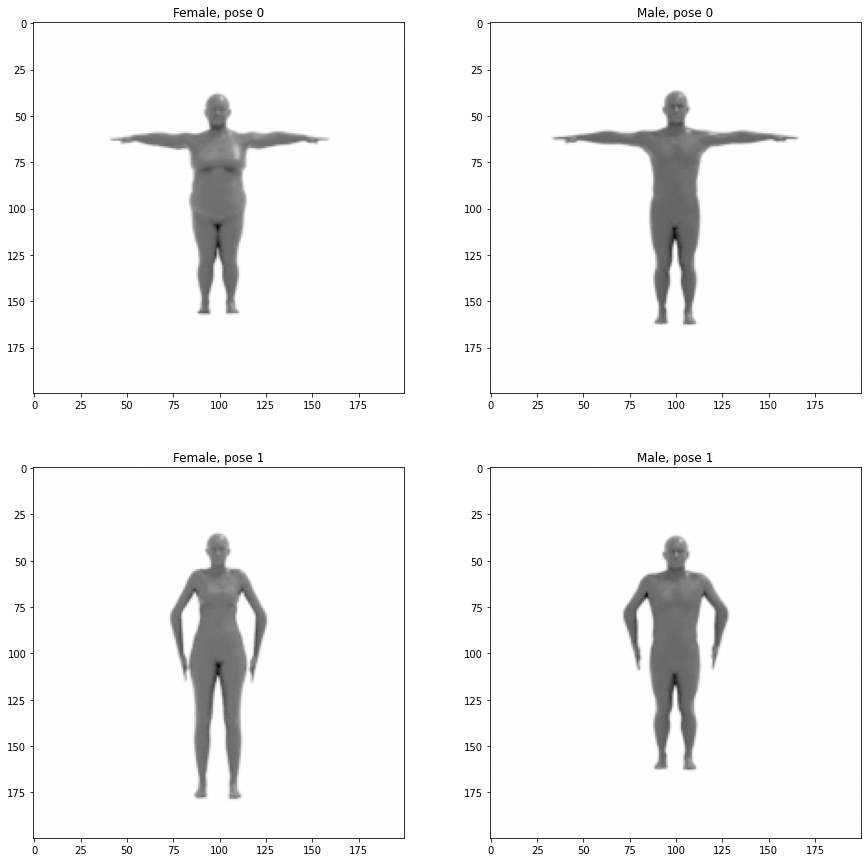

In [6]:
# Review data
plt.figure(figsize=(15, 15))
plt.subplot(221), plt.imshow(im_data[0], cmap='gray'), plt.title("Female, pose 0")
plt.subplot(222), plt.imshow(im_data[3001], cmap='gray'), plt.title("Male, pose 0")
plt.subplot(223), plt.imshow(im_data[6001], cmap='gray'), plt.title("Female, pose 1")
plt.subplot(224), plt.imshow(im_data[9001], cmap='gray'), plt.title("Male, pose 1")

In [7]:
# Dataset class
class BodyImages(Dataset):
    def __init__(self, X, y, is_training) -> None:
        assert X.shape[0] == y.shape[0], "Sample amounts must match in X and y"
        self.X = X
        self.y = y
        self.is_training = is_training

        if torch.cuda.is_available(): 
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

        super().__init__()
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.unsqueeze(torch.tensor(self.X[idx,:,:], requires_grad=True, device=self.device), 0), torch.tensor(self.y[idx, :], device=self.device)

# Prepare occluded images

In [ ]:
# Load occluded images from file or generate them
if os.path.exists(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH):
    im_data_occl = np.load(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH)

else:
    # Seed pseudo-random number generator for reproducibility
    random.seed(a="HBDE from occluded images", version=2)

    # Add rectangles to images
    im_data_occl = []
    for img_np in test_data:
        # Determine position, length and width of occluding rectangle
        upper_left_x = random.randrange(0, 200)
        upper_left_y = random.randrange(0, 200)
        lower_right_x = upper_left_x + random.randrange(0, 50)
        lower_right_y = upper_left_y + random.randrange(0, 50)

        # Convert from NumPy array to instance of Pillow Image class
        img = Image.fromarray(img_np)

        # Draw rectangles
        draw = ImageDraw.Draw(img)
        draw.rectangle((upper_left_x, upper_left_y, lower_right_x, lower_right_y), fill="black")

        # Add manipulated image to array of occluded images
        im_data_occl.append(np.asarray(img))
        
    im_data_occl = np.array(im_data_occl)
    with open(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH, "wb+") as f:
        np.save(f, im_data)
    f.close()

if not im_data.shape == (1200, 200, 200):
    Exception("Problems with occuluded image data.")

In [ ]:
# Review data
plt.figure(figsize=(15, 15))
plt.subplot(221), plt.imshow(im_data_occl[0], cmap='gray'), plt.title("Female, pose 0")
plt.subplot(222), plt.imshow(im_data_occl[301], cmap='gray'), plt.title("Male, pose 0")
plt.subplot(223), plt.imshow(im_data_occl[601], cmap='gray'), plt.title("Female, pose 1")
plt.subplot(224), plt.imshow(im_data_occl[901], cmap='gray'), plt.title("Male, pose 1")

## Create the CNN
Selected features (6): 
- height
- shoulder width
- right arm length
- left arm length
- pelvis circumifrence
- chest circumifrence


In [8]:
feature_amnt = 6

class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layers = Sequential(
            Conv2d(in_channels=1, out_channels=feature_amnt, kernel_size=5),
            ReLU(inplace=True),
            BatchNorm2d(num_features=feature_amnt),
            MaxPool2d(kernel_size=5, stride=2),
            # Second convolutional layer
            Conv2d(in_channels=6, out_channels=(feature_amnt*2), kernel_size=5),
            ReLU(inplace=True),  # Are these irrelevant?
            BatchNorm2d(num_features=feature_amnt*2),  # Are these irrelevant?
            MaxPool2d(kernel_size=5, stride=2),
        )
        self.linear_layers = Sequential(
            Linear(in_features=23232, out_features=23232),  # Drop the out feature amount here?
            ReLU(inplace=True),
            Linear(in_features=23232, out_features=feature_amnt)
        )
    
    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = self.linear_layers(x)
        return x

## Train the model

In [9]:
def train(model, optim, loss_fn, dataloader):
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        # Zero-out gradients
        optim.zero_grad()
        # Forward pass
        pred = model(X)
        # Compute loss
        loss = loss_fn(pred, y)
        # Backward pass and gradient computation
        loss.backward()
        # Parameter update
        optim.step()

def test(dataloader, model, loss_fn):
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y)
            # print(test_loss)
            # correct += (torch.argmax(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    # correct /= size
    print(f"Avg loss: {test_loss:>8f} \n")

torch.cuda.empty_cache()

train_data_ds = BodyImages(train_data, train_annos, is_training=True)
test_data_ds = BodyImages(test_data, test_annos, is_training=False)
train_dataloader = DataLoader(train_data_ds, batch_size=100)
test_dataloader = DataLoader(test_data_ds, batch_size=100)

network = CNN()
optimizer = SGD(network.parameters(),lr=0.001, momentum=0.9)
loss_fn = MSELoss()
epochs = 20

if torch.cuda.is_available(): 
    device = torch.device('cuda')
    network.cuda()
    loss_fn.cuda()
else:
    device = torch.device('cpu')
  
print('Using:', device, "\n")

for e in range(epochs):
    print("-"*15, "epoch:", e + 1, "-"*15)
    train(network, optimizer, loss_fn, train_dataloader)
    test(train_dataloader, network, loss_fn)

Using: cuda 

--------------- epoch: 1 ---------------
Avg loss: 0.003927 

--------------- epoch: 2 ---------------
Avg loss: 0.002392 

--------------- epoch: 3 ---------------
Avg loss: 0.001847 

--------------- epoch: 4 ---------------
Avg loss: 0.001564 

--------------- epoch: 5 ---------------
Avg loss: 0.001390 

--------------- epoch: 6 ---------------
Avg loss: 0.001271 

--------------- epoch: 7 ---------------
Avg loss: 0.001197 

--------------- epoch: 8 ---------------
Avg loss: 0.001129 

--------------- epoch: 9 ---------------
Avg loss: 0.001086 

--------------- epoch: 10 ---------------
Avg loss: 0.001045 

--------------- epoch: 11 ---------------
Avg loss: 0.001013 

--------------- epoch: 12 ---------------
Avg loss: 0.000991 

--------------- epoch: 13 ---------------
Avg loss: 0.000967 

--------------- epoch: 14 ---------------
Avg loss: 0.000948 

--------------- epoch: 15 ---------------
Avg loss: 0.000934 

--------------- epoch: 16 ---------------
Avg loss